In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tarfile
import requests
from typing import Tuple
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
sns.set_theme()

In [3]:
def load_housing_data(url: str, download_dir: Path) -> pd.DataFrame:
    housing_csv_path = Path.joinpath(download_dir, "housing/housing.csv")

    if not housing_csv_path.is_file():
        local_filename = Path.joinpath(download_dir, url.split("/")[-1])
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

        with tarfile.open(local_filename) as tarball:
            tarball.extractall(path=download_dir)

    return pd.read_csv(housing_csv_path)

## Get data


In [4]:
url = "https://github.com/ageron/data/raw/main/housing.tgz"
download_dir = Path("../datasets/")
housing_df = load_housing_data(url, download_dir)
housing_df = housing_df.reset_index()

In [5]:
housing_df.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [17]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [18]:
housing_df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [19]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

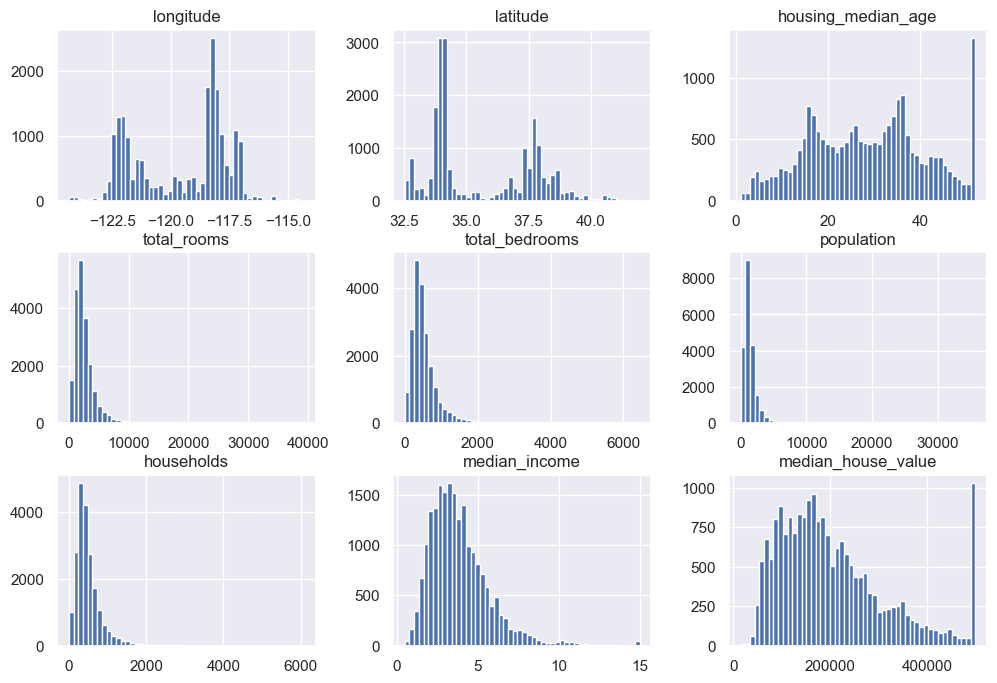

In [21]:
housing_df.hist(bins=50, figsize=(12, 8))

Observations

- Median income is not expressed in USD. The data has been scaled and capped at 15.
- housing_median_age and median_house_value are also capped. The capping of median_house_value can be problematic as the model may learn that median_house_value can never be greater than $500000.
- The attributes have very different scales.
- Many histograms are skewed to the right. This may be problematic for linear regression as the algorithm requires the features to be approximately normally distributed.


## Create a test set


In [6]:
def shuffle_and_split_data(
    data: pd.DataFrame, test_ratio: float
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    n_samples = len(data)
    shuffled_indices = np.random.permutation(n_samples)
    test_set_size = int(n_samples * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


def shuffle_and_split_data_with_id_hash(
    data: pd.DataFrame, test_ratio: float, id_col: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ids = data[id_col]
    test_set_id_mask = ids.apply(lambda x: is_id_in_test_set(x, test_ratio))
    return data.loc[~test_set_id_mask], data[test_set_id_mask]


def is_id_in_test_set(id: int, test_ratio: float) -> bool:
    return crc32(np.int64(id)) < test_ratio * 2**32

`shuffle_and_split_data` works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your machine learning algorithms) will get to see the whole dataset, which is what you want to avoid. To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have unique and immutable identifiers). For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value.


In [7]:
train_set, test_set = shuffle_and_split_data_with_id_hash(
    housing_df, test_ratio=0.2, id_col="index"
)

In [8]:
len(train_set)

16512

In [9]:
len(test_set)

4128

### Stratified sampling based on median income


In [11]:
housing_df["income_cat"] = pd.cut(
    housing_df["median_income"],
    bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

In [12]:
housing_df.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


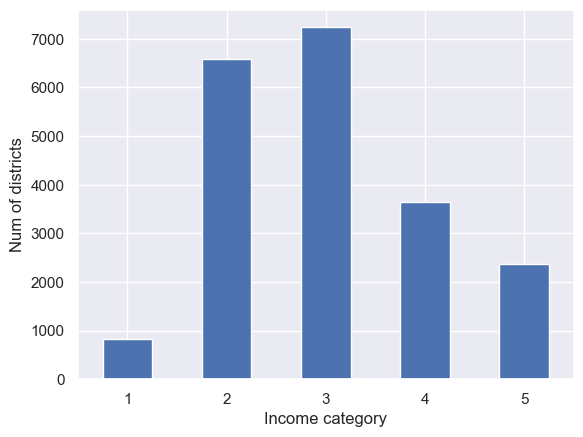

In [13]:
housing_df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Num of districts")
plt.show()

In [15]:
strat_train_set, strat_test_set = train_test_split(
    housing_df, test_size=0.2, stratify=housing_df["income_cat"], random_state=42
)

In [16]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

## Explore and visualize data to gain insights

- Make sure to put the test set aside and only explore the training set
- If the training set is very large, you may sample an exploration set to make the manipulations easy
- Make a copy of the training dataset since we will make various data transformations

In [17]:
housing_df = strat_train_set.copy()

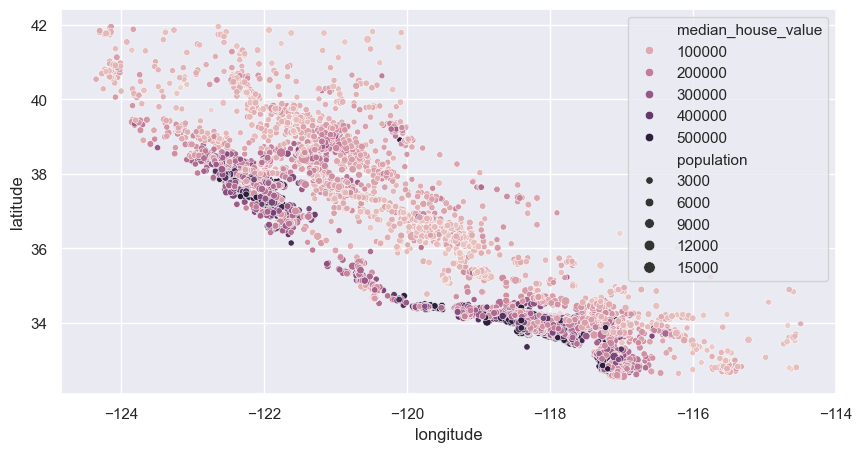

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    data=housing_df,
    x="longitude",
    y="latitude",
    hue="median_house_value",
    size="population",
    ax=ax,
)
plt.show()

The image tells that the housing prices are related to population and location (close to ocean).

### Correlations

In [27]:
housing_num_cols_df = housing_df[
    [
        "median_house_value",
        "longitude",
        "latitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income",
    ]
]

In [28]:
corr_matrix = housing_num_cols_df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

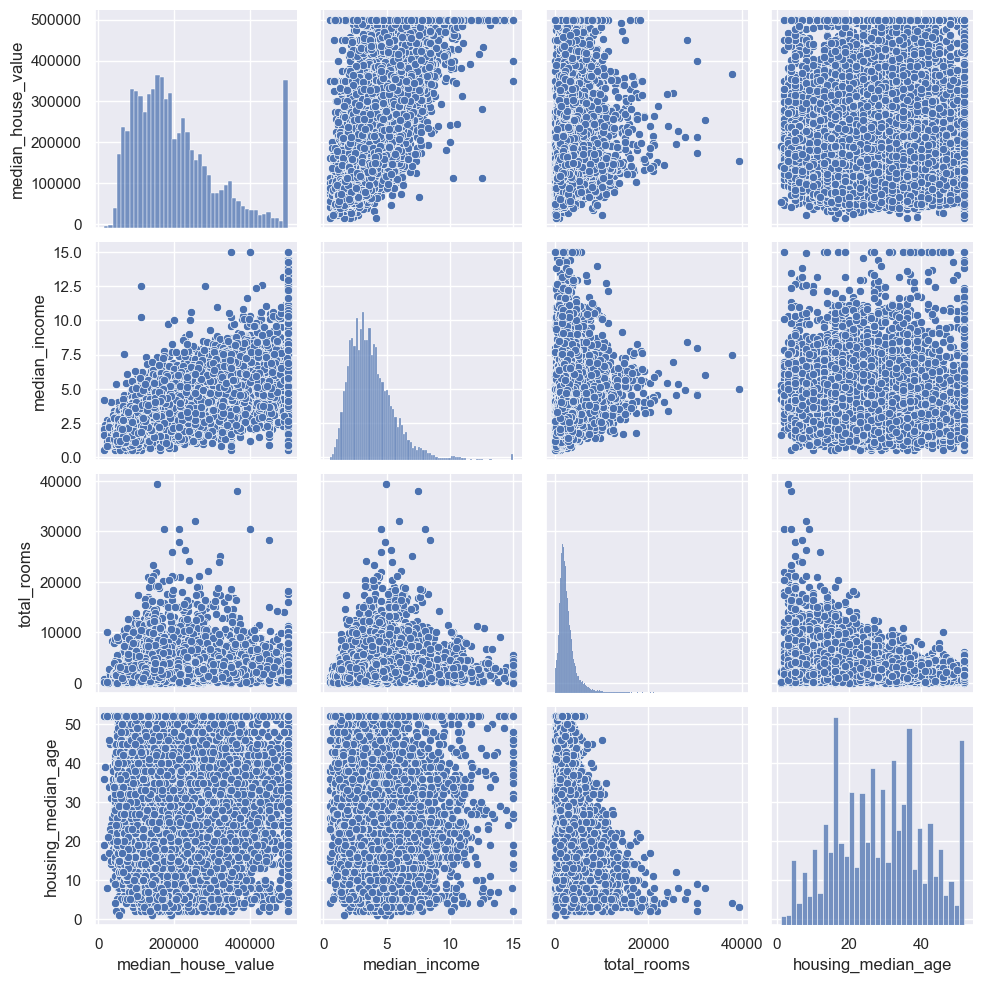

In [36]:
attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age",
]
sns.pairplot(housing_df[attributes])
plt.show()

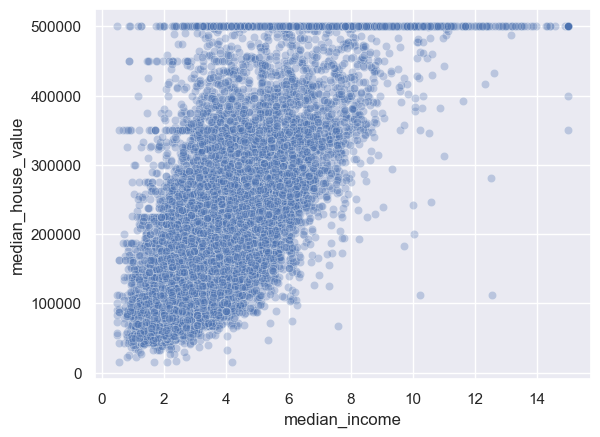

In [ ]:
sns.scatterplot(data=housing_df, x="median_income", y="median_house_value", alpha=0.3)
plt.show()

### Experiment with attribute combinations

In [42]:
housing_df["rooms_per_house"] = housing_df["total_rooms"] / housing_df["households"]
housing_df["bedrooms_ratio"] = housing_df["total_bedrooms"] / housing_df["total_rooms"]
housing_df["people_per_house"] = housing_df["population"] / housing_df["households"]

In [45]:
attributes = [
    "median_house_value",
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "rooms_per_house",
    "bedrooms_ratio",
    "people_per_house",
]
corr_matrix = housing_df[attributes].corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

## Prepare data for ML algorithms

In [61]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [63]:
housing.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN


In [59]:
housing_labels.head()

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

### Clean data

**Handle missing values**

We can use the following options to handle missing values:
1. Get rid of the rows containing missing values
2. Get rid of the whole attribute
3. Set the missing values to some non-zero value. 

In [ ]:
num_attributes = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
]
housing_num = housing[num_attributes]
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [70]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [71]:
X = imputer.transform(housing_num)